<a href="https://colab.research.google.com/github/jpsiegel/Projects/blob/master/Tarea3_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tarea 3 Jan P. Siegel - Deep Learning


###Allocate resources

In [2]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil

import os
import GPUtil as GPU
import psutil
import humanize

GPUs = GPU.getGPUs()
gpu = GPUs[0]  # Only one GPU on Colab and not guaranteed

def printm():
  process = psutil.Process(os.getpid())
  print("RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " | Used: " + humanize.naturalsize(process.memory_info().rss))
  print("VRAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()


RAM Free: 12.8 GB  | Used: 120.5 MB
VRAM Free: 15109MB | Used: 0MB | Util   0% Total 15109MB


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
my_dir = "/content/drive/MyDrive/DL"

Mounted at /content/drive


In [3]:
# Download Roms
!wget http://www.atarimania.com/roms/Roms.rar > /dev/null
# Decompresed files
!unrar e Roms.rar > /dev/null
!unzip 'ROMS.zip' > /dev/null
# Add Roms folder to atary_py PATH
!python -m atari_py.import_roms 'ROMS' > /dev/null
# > /dev/null omits command output

--2021-06-24 20:38:44--  http://www.atarimania.com/roms/Roms.rar
Resolving www.atarimania.com (www.atarimania.com)... 195.154.81.199
Connecting to www.atarimania.com (www.atarimania.com)|195.154.81.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11128004 (11M) [application/x-rar-compressed]
Saving to: ‘Roms.rar’

Roms.rar            100%[===================>]  10.61M   471KB/s    in 24s     

2021-06-24 20:39:08 (457 KB/s) - ‘Roms.rar’ saved [11128004/11128004]



###Preprocessing


In [4]:
import gym
from gym import spaces
import cv2

# pasar a escala de grises y recortar imagen
def _process_frame84(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    frame = frame[:155,10:]
    #x_t = cv2.resize(frame, (84, 84),  interpolation=cv2.INTER_LINEAR)
    x_t = cv2.resize(frame, (84, 84),interpolation=cv2.INTER_AREA)
    return x_t.astype(np.uint8)

class ProcessFrame84(gym.Wrapper):
    def __init__(self, env=None):
        super(ProcessFrame84, self).__init__(env)
        self.observation_space = spaces.Box(low=0, high=255, shape=(84, 84))

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        return _process_frame84(obs), reward, done, info

    def reset(self):
        return _process_frame84(self.env.reset())

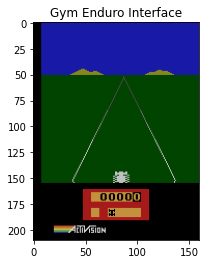

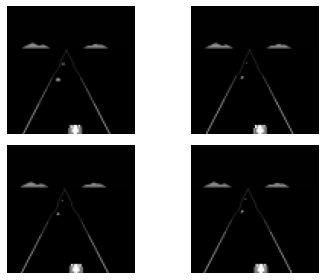

obs shape: (4, 84, 84)
actions: ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'DOWN', 'DOWNRIGHT', 'DOWNLEFT', 'RIGHTFIRE', 'LEFTFIRE'] amount: 9


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import random
from gym.wrappers import AtariPreprocessing
from gym.wrappers import FrameStack

#Create environment
game = 'Enduro-v0'
env = gym.make(game,frameskip=4)

# For reproducibility
seed = 0
env.seed(seed)

obs = env.reset()

plt.imshow(np.squeeze(obs))
plt.title('Gym Enduro Interface')
plt.show()

env = ProcessFrame84(env) # pasamos el wrapper al enviroment
env = FrameStack(env,num_stack=4) # un estado definido como el actual mas los 3 anteriores
obs = env.reset()

for _ in range(100):
  action = random.randint(0,env.action_space.n-1)
  obs, reward, done, info = env.step(action)

plt.figure()
plt.subplot(2,2,1)
plt.imshow(np.squeeze(np.array(obs)[0,:,:]),cmap='gray')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(np.squeeze(np.array(obs)[1,:,:]),cmap='gray')
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(np.squeeze(np.array(obs)[2,:,:]),cmap='gray')
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(np.squeeze(np.array(obs)[3,:,:]),cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

print("obs shape:", obs.shape)
print("actions:", env.get_action_meanings(), "amount:", env.action_space.n)

In [21]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = [] # Can be a list a Deque or another type of list

    def push(self, state, action, next_state, reward, done):
        """Saves a transition.
        e.g. ('state', 'action', 'next_state', 'reward','done')
        """
        memory_data = (state, action, next_state, reward, done)
        self.memory.append(memory_data)

    def sample(self, batch_size):
       """ Samples a transition with a defined batch size"""
       return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

###Model

In [22]:
import torch
import torch.nn as nn
import numpy as np

class Dueling_DQN(nn.Module):
    def __init__(self, in_channels, num_actions):
        super(Dueling_DQN, self).__init__()
        self.num_actions = num_actions
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)

        self.fc1_adv = nn.Linear(in_features=7*7*64, out_features=512)
        self.fc1_val = nn.Linear(in_features=7*7*64, out_features=512)

        self.fc2_adv = nn.Linear(in_features=512, out_features=num_actions)
        self.fc2_val = nn.Linear(in_features=512, out_features=1)

        self.relu = nn.ReLU()

    def forward(self, x):

        # TODO: forward pass red convolucional
        
        # TODO: forward pass rama fully-connected para V(s)
        
        # TODO: forward pass rama fully-connected para A(s,a)
        
        # TODO: Calculo de Q(s,a) a partir de ecuacion (4)

        return Q_values

###Training

In [ ]:
import torch.optim as optim
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

replay_buffer_size=500_000
batch_size = 32
gamma = 0.99 # Discounted return
learning_starts = 50000 # Paso en que se comienza a utilizar la red para escoger acciones (siguiendo política e-greedy)
learning_freq = 4 # Frecuencia de pasos en que se ejecuta una propagación error (loss) en la red
frame_history_len = 4 # Cantidad de frames de cada estado (definido en el pre-procesamiento)
target_update_freq=10000 # Frecuencia en que se actualizan los pesos de la red target
LR = 0.00025 # Tasa de aprendizaje

in_channels = frame_history_len
input_shape = (84,84)
num_actions = env.action_space.n

# define Q target and Q 
Q = Dueling_DQN(in_channels, num_actions).to(device)
Q_target = Dueling_DQN(in_channels, num_actions).to(device)

# Optimizador, pueden elegir entre Adam o RMSProp

# Criterio de pérdida

# Creamos nuestra memoria de estados
replay_memory = ReplayMemory(replay_buffer_size)

LOG_EVERY_N_STEPS = 50_000 # (Opcional) Frecuencia en la que se muestran resultados en consola
STEPS_PER_EPOCH = 250_000 # Pasos por época
N_EPOCHS = 20 # Número de épocas

# Load checkpoint

# Reseteamos nuestro ambiente para empezar el entrenamiento
last_obs = env.reset()
for epoch in tqdm(range(N_EPOCHS),position=0,leave=True):
  for t in tqdm(range(STEPS_PER_EPOCH),position=0,leave=True):
    #1. before learning starts, choose actions randomly
    if t < learning_starts:
      action = np.random.randint(num_actions)
    else:
      # epsilon greedy exploration
      sample = random.random()
      # la funcion exploration permite calcular el threshold para la política e-greedy
      threshold = exploration(t) 
      if sample > threshold:
        with torch.no_grad():
          # Calculo de la acción con la red Q
          pass
      else:
        action = np.random.randint(num_actions)

    obs, reward, done, info = env.step(action)

    replay_memory.push(last_obs, action, obs, reward, done)
    if done:
      obs = env.reset()
      # Guardar reward acumulado del episodio

    # update last_obs
    last_obs = obs


    ### 2. Perform experience replay and train the network.
    if (t > learning_starts and t % learning_freq == 0):
      obs_t, act_t, rew_t, next_obs, done_mask = replay_memory.sample(batch_size)
          
      # Pasar los arreglos a tensores y al device actual
      # No olviden normalizar sus tensores de entrada

      # input batches to networks
      q_values = Q(obs_t)

      # Loss calculation

      # backwards pass
      optimizer.zero_grad()

      loss.backward()
      # update
      optimizer.step()

      # Actualizar pesos de red target (cada target_update_freq actualizaciones de los parámetros de Q)

    
    if t % LOG_EVERY_N_STEPS == 0:
      # Mostrar resultados actuales
      # e.g. Mejor reward y promedio de ultimos 100 episodios
      # entre otros.
      pass

    # Guardar modelo y resultados!
    # importante si se les cierra el entrenamiento